## Model Training


#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score,mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV ,train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector

In [2]:
df = pd.read_csv('../data/stud.csv')

In [3]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
X = df.drop(columns=['math_score'], axis=1)
y = df['math_score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), selector(dtype_exclude='object')),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
               selector(dtype_include='object')),
    ]
)

In [12]:
from sklearn.metrics import mean_absolute_error


def evaluate_model(true, predicted):
    mae  = mean_absolute_error(true, predicted)
    # rmse = mean_squared_error(true, predicted, squared=False)
    r2   = r2_score(true, predicted)
    return mae, r2

In [10]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=42),
}
if XGBRegressor is not None:
    models["XGBRegressor"] = XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1
    )
if CatBoostRegressor is not None:
    models["CatBoosting Regressor"] = CatBoostRegressor(
        depth=6, learning_rate=0.05, n_estimators=500,
        random_state=42, verbose=False
    )

In [17]:
model_list = []
r2_list = []
results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('prep', preprocessor),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    y_test_pred  = pipe.predict(X_test)

    model_train_mae,  model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae,  model_test_r2  = evaluate_model(y_test,  y_test_pred)

    print(name)
    print('Model performance for Training set')
    # print(f"- Root Mean Squared Error: {model_train_rmse:.4f}")
    print(f"- Mean Absolute Error:     {model_train_mae:.4f}")
    print(f"- R2 Score:                {model_train_r2:.4f}")
    print('----------------------------------')
    print('Model performance for Test set')
    # print(f"- Root Mean Squared Error: {model_test_rmse:.4f}")
    print(f"- Mean Absolute Error:     {model_test_mae:.4f}")
    print(f"- R2 Score:                {model_test_r2:.4f}")
    print('='*35, '\n')

    model_list.append(name)
    r2_list.append(model_test_r2)
    results.append({
        "Model": name,
        "Train_MAE": model_train_mae, "Train_R2": model_train_r2,
        "Test_MAE":  model_test_mae,  "Test_R2":  model_test_r2,
        "Pipeline": pipe
    })

Linear Regression
Model performance for Training set
- Mean Absolute Error:     4.2667
- R2 Score:                0.8743
----------------------------------
Model performance for Test set
- Mean Absolute Error:     4.2148
- R2 Score:                0.8804

Lasso
Model performance for Training set
- Mean Absolute Error:     5.2053
- R2 Score:                0.8072
----------------------------------
Model performance for Test set
- Mean Absolute Error:     5.1557
- R2 Score:                0.8254

Ridge
Model performance for Training set
- Mean Absolute Error:     4.2650
- R2 Score:                0.8743
----------------------------------
Model performance for Test set
- Mean Absolute Error:     4.2111
- R2 Score:                0.8806

K-Neighbors Regressor
Model performance for Training set
- Mean Absolute Error:     4.5127
- R2 Score:                0.8557
----------------------------------
Model performance for Test set
- Mean Absolute Error:     5.6020
- R2 Score:                0.78

In [16]:
summary = pd.DataFrame(results).drop(columns=['Pipeline']).sort_values("Test_R2", ascending=False).reset_index(drop=True)
print("\n=== Summary (sorted by Test R²) ===")
print(summary.to_string(index=False))

best_row = summary.iloc[0]
print(f"\nBest model: {best_row['Model']} | Test R²: {best_row['Test_R2']:.4f}")


=== Summary (sorted by Test R²) ===
                  Model  Train_MAE  Train_R2  Test_MAE  Test_R2
                  Ridge   4.265005  0.874304  4.211113 0.880592
      Linear Regression   4.266712  0.874317  4.214763 0.880433
  CatBoosting Regressor   2.888157  0.941523  4.549208 0.856683
     AdaBoost Regressor   4.730278  0.851795  4.681343 0.851649
Random Forest Regressor   1.824858  0.976464  4.701467 0.850393
           XGBRegressor   0.794469  0.994578  4.788170 0.840643
                  Lasso   5.205260  0.807223  5.155701 0.825447
  K-Neighbors Regressor   4.512750  0.855668  5.602000 0.785652
          Decision Tree   0.018750  0.999653  6.240000 0.747348

Best model: Ridge | Test R²: 0.8806


In [22]:
summary = pd.DataFrame({
    "Model": model_list,
    "Test_R2": r2_list
}).sort_values("Test_R2", ascending=False)
summary


,Model,Test_R2
2,Ridge,0.880592
0,Linear Regression,0.880433
8,CatBoosting Regressor,0.856683
6,AdaBoost Regressor,0.851649
5,Random Forest Regressor,0.850393
7,XGBRegressor,0.840643
1,Lasso,0.825447
3,K-Neighbors Regressor,0.785652
4,Decision Tree,0.747348


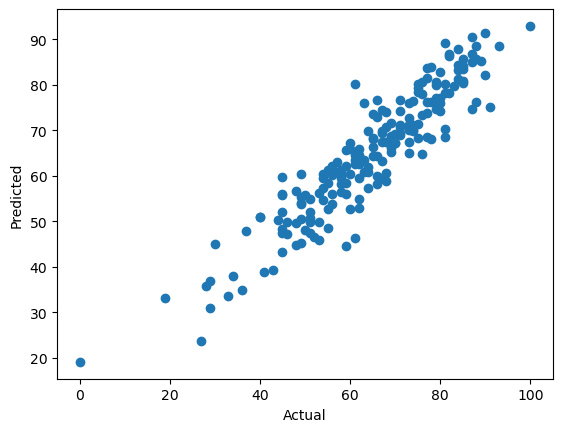

In [24]:
plt.scatter(y_test,y_test_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

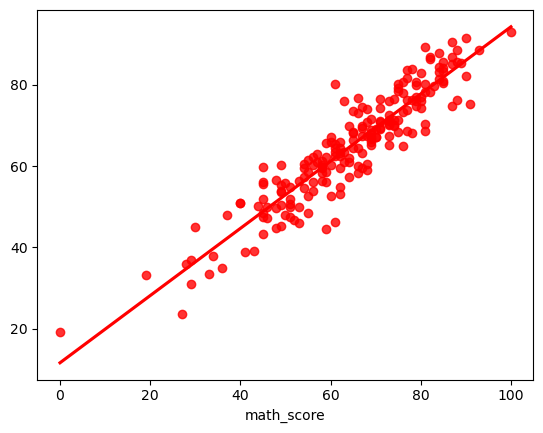

In [25]:
sns.regplot(x=y_test,y=y_test_pred,ci=None,color ='red');

In [26]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_test_pred,'Difference':y_test-y_test_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,75.256750,15.743250
737,53,56.280441,-3.280441
740,80,77.090476,2.909524
660,74,76.490561,-2.490561
411,84,87.883810,-3.883810
...,...,...,...
408,52,46.681135,5.318865
332,62,59.556648,2.443352
208,74,69.861842,4.138158
613,65,68.031032,-3.031032
